**EDA**
* Correlation between host and athletes performance(does host select events? or just direct effect?) (overall and Gold)(ewa of previous, host, and next)
* Trend of number of medals over time
* Special sports for each country(pingpong China, basketball the USA)

**Data Proprocessing:**
* Handling historical data, Olympics in the early 20th century were vastly different from modern ones in terms of participation, number of events, etc. Countries that were dominant in earlier years may not reflect current or future trends. Global events like WWI influence Olympics. To handle it, use weighted importance, for example w_year = exp(-k(2028-year))
* Remove data for sports that are not in recent years.
* About year, use the recent 2-3 olympics as validation data. How to select the range for training? How to deal with years in WWI and WWII?
* Remove the athletes that are not in the 2020 and 2024 olympics, consider how to handle new athletes
* Rows are sport name, columns are country_medaltype, entries are ewa with param=0.8(average last 5 times, 20 years) for historical medal counts. Think about how do feature engineer and EDA

**Feature Engineering**
* Athletes' participation times to estimate age. EDA of distribution of ages of medals
* From Athletes_file, count medals for each sport of each country, sport as a column in medal_file, use this to replace medal_file(so rows number from original year times country to year times country times sport)
* 技术性或体力性
* KNN as denotation of GDP/population
* Athletes number vs medal counts. EDA, .corr()
* Group medals(divided by the number of members)

**Questions**
* Athletes attending 2028? new athletes?
* Which model is the best? What is the target? What is the format of the target?(1 Gold for each sport, then the best way is to make a prediction for each sport. However, it cannot be done due to the model complexity and the lack of 2028 gymnasts data.) If directly predict the medal counts, how to concatenate the dataframes/feature engineering?(One thought is summarize the athletes data for each country)
* Is there a limit of number of events an athletes can attend?(like attend in similar disciplines in a sport) What if some country dont have enough athletes.
* How to use athletes data combine with number of discipline

**Training Data Columns(If NN, using log for skewed features. Shift)** 
medals.columns, sport_type, 技术性或体力性?, ewa of medal counts as country specialization, average athletes score in recent 2 games, host country, Athletes number, KNN?(x=index,y=medal_count), athletes data?

A separate classifier for first time medal, remove China as outlier(EDA, large territory and population, which means large athletes pool)

**Great Coach**
* EDA or use medal counts for year t minus year (t-1) > 3.

**Training Data Structure type**
1. medals_file
2. medals_file.columns + sport_type
3. predict winning for each athlete(no athletes data for 2028)

distribution of medal

for athletes, medal counts divided by events counts

Use proportion for medal count, athletes count, 
ewa medal/event

Team members count


**Current Training Columns**
* Features: Host, Medal_EWA, Events, Athletes_Counts, Athletes_Proportion, NOC(replaced with KNN_Total), 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from scipy.stats import ttest_ind, norm
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import NearestNeighbors

from statsmodels.graphics.tsaplots import plot_pacf

data_dict = pd.read_csv(r"2025_Problem_C_Data\data_dictionary.csv", encoding="latin-1")
                        
athletes = pd.read_csv(r"2025_Problem_C_Data\summerOly_athletes.csv")
hosts = pd.read_csv(r"2025_Problem_C_Data\summerOly_hosts.csv")
medal = pd.read_csv(r"2025_Problem_C_Data\summerOly_medal_counts.csv")
programs = pd.read_csv(r"2025_Problem_C_Data\summerOly_programs.csv", encoding='windows-1252')
hosts = hosts.drop(hosts.index[hosts['Year'].isin([1916, 1940, 1944])]) #Drop years during WW
athletes['NOC'] = athletes['NOC'].replace('AIN', 'ROC') #2024 ROC Team
programs.rename(columns={'1906*': '1906'}, inplace=True) #Replace 906* as 1906

y_2028_sports = pd.read_csv(r"2025_Problem_C_Data\summerOly_2028_Sports.csv")

In [2]:
athletes_clean = athletes.drop_duplicates(subset=['Year', 'NOC', 'Name'])

# Sort by Year to ensure chronological order
athletes_sorted = athletes_clean.sort_values(by='Year')

# Calculate participation_time (cumulative count of participations per athlete)
athletes_sorted['participation_time'] = athletes_sorted.groupby(['NOC', 'Name'])['Year'] \
                                                       .rank(method='first', ascending=True) \
                                                       .astype(int)
athletes_sorted[['Name', 'NOC', 'Year', 'participation_time']]

athletes_sorted['Medal_Count'] = (athletes_sorted['Medal'] != 'No medal').astype(int)
athletes_sorted

,Name,Sex,Team,NOC,Year,City,Sport,Event,Medal,participation_time,Medal_Count
205677,Kharilaos Vasilakos,M,Greece,GRE,1896,Athina,Athletics,Athletics Men's Marathon,Silver,1,1
212160,Hermann Weingrtner,M,Germany,GER,1896,Athina,Gymnastics,Gymnastics Men's Horse Vault,Bronze,1,1
212525,Joseph Welzenbacher,M,Germany,GER,1896,Athina,Cycling,Cycling Men's 100 kilometres,No medal,1,0
88927,Alexander Jensen,M,Denmark,DEN,1896,Athina,Weightlifting,"Weightlifting Men's Unlimited, One Hand",Silver,1,1
153260,Petros Persakis,M,Greece,GRE,1896,Athina,Gymnastics,Gymnastics Men's Rings,Bronze,1,1
...,...,...,...,...,...,...,...,...,...,...,...
242565,Igor Radivilov,M,Ukraine,UKR,2024,Paris,Artistic Gymnastics,Men,No medal,2,0
242573,Radomyr Stelmakh,M,Ukraine,UKR,2024,Paris,Artistic Gymnastics,Men,No medal,1,0
242581,Anna Lashchevska,F,Ukraine,UKR,2024,Paris,Artistic Gymnastics,Women,No medal,1,0
242536,KUZYA,M,Ukraine,UKR,2024,Paris,Breaking,B-Boys,No medal,1,0


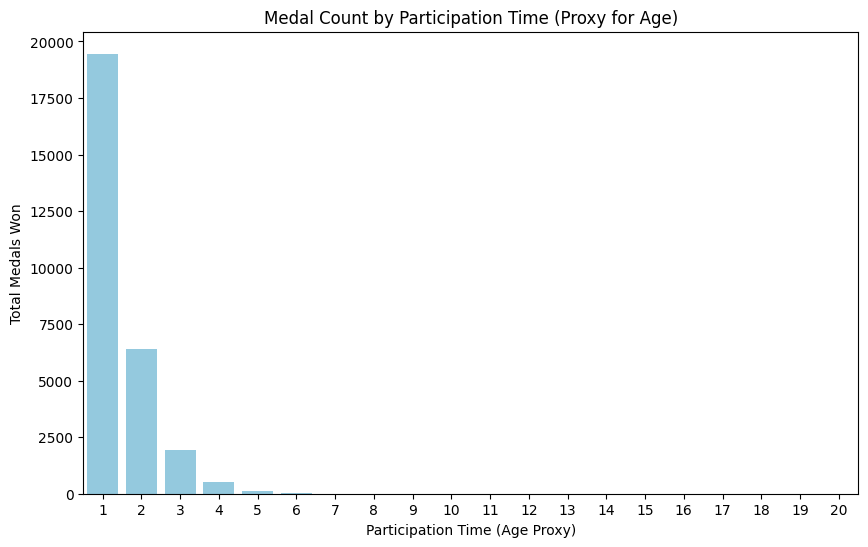

In [3]:
medal_distribution = athletes_sorted.groupby('participation_time')['Medal_Count'].sum().reset_index()
medal_distribution.columns = ['participation_time', 'Total_Medals']
plt.figure(figsize=(10, 6))
sns.barplot(x='participation_time', y='Total_Medals', data=medal_distribution, color='skyblue')
plt.title('Medal Count by Participation Time (Proxy for Age)')
plt.xlabel('Participation Time (Age Proxy)')
plt.ylabel('Total Medals Won')
plt.show()

In [4]:
def medal_count_for_each_sport(athletes):
    train = (
        athletes[['Year', 'NOC', 'Sport', 'Event', 'Medal']]
        .drop_duplicates()
        .groupby(['Year', 'NOC', 'Sport', 'Medal'])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    ).sort_values(by=['Year', 'Gold', 'Silver', 'Bronze'], ascending=[False, False, False, False])
    
    athlete_count = (
        athletes[['Year', 'NOC', 'Sport', 'Name']]
        .drop_duplicates()
        .groupby(['Year', 'NOC', 'Sport'])
        .size()
        .reset_index(name='Athlete_Count')
    )
    
    sport_athlete_count = (
        athletes[['Year', 'Sport', 'Name']]
        .drop_duplicates()
        .groupby(['Year', 'Sport'])
        .size()
        .reset_index(name='Sport_Athlete_Count')
    )

    train = train.merge(athlete_count, on=['Year', 'NOC', 'Sport'], how='left')
    train = train.merge(sport_athlete_count, on=['Year', 'Sport'], how='left')

    train['Athlete_Proportion'] = train['Athlete_Count'] / train['Sport_Athlete_Count']

    train = train.loc[:, ['Year', 'NOC', 'Sport', 'Gold', 'Silver', 'Bronze', 'Athlete_Count', 'Sport_Athlete_Count', 'Athlete_Proportion']]
    return train.reset_index(drop=True)

def create_2028_rows(train):
    df_2028 = train[(train['Year'] >= 1999)]
    noc_sport_combinations = df_2028.groupby(['NOC', 'Sport']).size().reset_index()[['NOC', 'Sport']]
    new_rows = pd.DataFrame({
        'Year': 2028,
        'NOC': noc_sport_combinations['NOC'],
        'Sport': noc_sport_combinations['Sport'],
        'Gold': 0,
        'Silver': 0,
        'Bronze': 0,
        'Athlete_Count': 0,
        'Sport_Athlete_Count': 0,
        'Athlete_Proportion': 0.0
    })

    return pd.concat([new_rows, train], ignore_index=True)

def merge_hosts(train, hosts):
    new_row = pd.DataFrame({'Year': [1906], 'Host': ['Athens, Greece']}) # Add 1906 Host
    hosts = pd.concat([hosts, new_row], ignore_index=True)
    
    country_to_noc = {
        "United States": "USA",
        "United Kingdom": "GBR",
        "France": "FRA",
        "Australia": "AUS",
        "Japan": "JPN",
        "Germany": "GER",
        "Greece": "GRE",
        "Brazil": "BRA",
        "China": "CHN",
        "Spain": "ESP",
        "South Korea": "KOR",
        "Russia": "RUS",
        "Canada": "CAN",
        "Mexico": "MEX",
        "Italy": "ITA",
        "Finland": "FIN",
        "Netherlands": "NED",
        "Belgium": "BEL",
        "Sweden": "SWE",
    }    
    hosts['Country'] = hosts['Host'].str.split(',').str[-1].str.strip()
    hosts['NOC'] = hosts['Country'].map(country_to_noc)
    hosts.loc[hosts['Year'] == 1972, 'NOC'] = 'FRG'
    hosts.loc[hosts['Year'] == 1980, 'NOC'] = 'URS'
    hosts.loc[hosts['Year'] == 2020, 'NOC'] = 'JPN'
    hosts = hosts.drop(['Host', 'Country'], axis=1)

    train = pd.merge(train, hosts, on='Year', how='left', suffixes=('', '_host'))
    train['NOC_if_host'] = train.apply(lambda row: 1 if row['NOC'] == row['NOC_host'] else 0, axis=1)
    return train

def add_2028_sports(programs, y_2028_sports):
    programs['Discipline'] = programs['Discipline'].fillna(programs['Sport'])

    programs['Sport'] = programs['Sport'].str.replace('\xa0', ' ', regex=True)

    programs['Sport'] = programs['Sport'].str.lower()
    programs['Discipline'] = programs['Discipline'].str.lower()
    y_2028_sports['Sport'] = y_2028_sports['Sport'].str.lower()
    y_2028_sports['Discipline'] = y_2028_sports['Discipline'].str.lower()

    if '2028' not in programs.columns:
        programs = programs.merge(y_2028_sports, how='left', left_on=['Sport', 'Discipline'], right_on=['Sport', 'Discipline'])
        programs['2028'] = programs['2028'].fillna(0).astype(int)
        programs.loc[71, '2028'] = programs.loc[:70, '2028'].sum()
    else:
        print("2028 column already exists")
    return programs

def merge_programs(train, programs):
    sport_to_code_mapping = {
        'Athletics': 'ATH',
        'Hockey': 'HOC',
        'Football': 'FBL',
        'Wrestling': 'WRG',
        'Boxing': 'BOX',
        'Judo': 'JUD',
        'Taekwondo': 'TKW',
        'Shooting': 'SHO',
        'Swimming': 'SWM',
        'Cycling Road': 'CRD',
        'Weightlifting': 'WLF',
        'Fencing': 'FEN',
        'Synchronized Swimming': 'SWA',
        'Sailing': 'SAL',
        'Equestrianism': 'EDR',
        'Triathlon': 'TRI',
        'Cycling': 'CTR',
        'Artistic Gymnastics': 'GAR',
        'Gymnastics': 'GAR',
        'Handball': 'HBL',
        'Tennis': 'TEN',
        'Volleyball': 'VVO',
        'Rowing': 'ROW',
        'Table Tennis': 'TTE',
        'Trampolining': 'GTR',
        'Badminton': 'BDM',
        'Canoe Sprint': 'CSP',
        'Karate': 'KTE',
        'Marathon Swimming': 'OWS',
        'Canoe Slalom': 'CSL',
        'Canoeing': 'CSP', 
        'Basketball': 'BKB',
        'Beach Volleyball': 'VBV',
        'Rugby': 'RUG',
        'Diving': 'DIV',
        'Figure Skating': 'FSK',
        'Polo': 'POL',
        'Water Polo': 'WPO',
        'Art Competitions': None,
        'Modern Pentathlon': 'MPN',
        'Archery': 'ARC',
        'Golf': 'GLF',
        'Rugby Sevens': 'RU7',
        'Cycling BMX Racing': 'BMX',
        'Cycling Mountain Bike': 'MTB',
        'Equestrian': 'EDR',
        'Surfing': 'SRF',
        'Cycling BMX Freestyle': 'BMF',
        'Skateboarding': 'SKB',
        'Rhythmic Gymnastics': 'GRY',
        'Softball': 'SBL',
        'Baseball': 'BSB',
        'Cycling Track': 'CTR',
        'Artistic Swimming': 'SWA',
        'Baseball/Softball': 'BSB',
        'Sport Climbing': 'CLB',
        'Trampoline Gymnastics': 'GTR',
        '3x3 Basketball': 'BK3',
        'Breaking': 'BKG',
        'Tug-Of-War': 'TOW',
        'Ice Hockey': 'IHO',
        'Lacrosse': 'LAX',
        'Basque Pelota': 'PEL',
        'Croquet': 'CQT',
        'Cricket': 'CKT',
        'Motorboating': None,
        'Racquets': 'RQT',
        'Jeu De Paume': '\x96',
        'Alpinism': None, 
        'Aeronautics': None,
        'Roque': 'ROC'
    }
    
    train['Sport_Code'] = train['Sport'].map(sport_to_code_mapping)
    train['Sport_Code'] = train['Sport_Code'].fillna('NAN')

    year_columns = [str(year) for year in list(range(1896, 2025, 4)) + ['1906']]
    for year_to_remove in ['1940', '1944', '1916']:
        year_columns = [year for year in year_columns if year != year_to_remove]
    
    melted_programs = pd.melt(
        programs,
        id_vars=['Sport', 'Discipline', 'Code', 'Sports Governing Body'],
        value_vars=year_columns,
        var_name='Year',
        value_name='Number_of_Events'
    ).sort_values(by=['Year', 'Sport'], ascending=[False, True]).loc[:, ['Year', 'Code', 'Number_of_Events']].fillna(0)
    
    train['Year'] = train['Year'].astype(int)
    melted_programs['Year'] = melted_programs['Year'].astype(int)
    
    merged_df = train.merge(
        melted_programs,
        left_on=['Year', 'Sport_Code'],
        right_on=['Year', 'Code'],
        how='left'
    ).drop(['Sport','Code'], axis=1)
    
    return merged_df

def add_Medal_EWA(train):
    GOLD_WEIGHT = 0.5
    SILVER_WEIGHT = 0.3
    BROUNZE_WEIGHT = 0.2
    beta = 0.8


    train['Number_of_Events'] = train['Number_of_Events'].fillna(0).astype(int)

    condition = (train['Number_of_Events'] != 0)

    train['current_year_value'] = 0
    train.loc[condition, 'current_year_value'] = (
        (GOLD_WEIGHT * train['Gold'] + SILVER_WEIGHT * train['Silver'] + BROUNZE_WEIGHT * train['Bronze']) /
        (train['Number_of_Events']))
    
    train['Medal_EWA'] = 0

    for noc, group in train.groupby(['NOC','Sport_Code']):
        ewa = 0
        t = 1
        for idx, row in group.iterrows():
            ewa = (beta * ewa + (1 - beta) * row['current_year_value']) / (1 - beta**t)
            train.loc[idx, 'Medal_EWA'] = ewa
            t += 1

    train.drop(columns=['current_year_value'], inplace=True)
    return train


def replace_noc_with_knn(train, n_neighbors=5):
    noc_medals = train.groupby('NOC')[['Gold', 'Silver', 'Bronze']].mean().reset_index()
    noc_medals['Total'] = noc_medals['Gold'] + noc_medals['Silver'] + noc_medals['Bronze']
    
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(noc_medals[['Gold', 'Silver', 'Bronze', 'Total']])

    noc_medals['KNN_Gold'] = 0.0
    noc_medals['KNN_Silver'] = 0.0
    noc_medals['KNN_Bronze'] = 0.0
    noc_medals['KNN_Total'] = 0.0

    for idx, row in noc_medals.iterrows():
        distances, indices = knn.kneighbors([row[['Gold', 'Silver', 'Bronze', 'Total']]])
        neighbor_medals = noc_medals.iloc[indices[0]][['Gold', 'Silver', 'Bronze', 'Total']].mean()
        noc_medals.at[idx, 'KNN_Gold'] = neighbor_medals['Gold']
        noc_medals.at[idx, 'KNN_Silver'] = neighbor_medals['Silver']
        noc_medals.at[idx, 'KNN_Bronze'] = neighbor_medals['Bronze']
        noc_medals.at[idx, 'KNN_Total'] = neighbor_medals['Total']

    train = train.merge(
        noc_medals[['NOC', 'KNN_Gold', 'KNN_Silver', 'KNN_Bronze', 'KNN_Total']],
        on='NOC',
        how='left'
    )

    return train

def plot_knn_comparison(train):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    sns.scatterplot(x='Gold', y='KNN_Gold', data=train)
    plt.title('Gold vs KNN_Gold')
    plt.xlabel('Original Gold')
    plt.ylabel('KNN_Gold')

    plt.subplot(2, 2, 2)
    sns.scatterplot(x='Silver', y='KNN_Silver', data=train)
    plt.title('Silver vs KNN_Silver')
    plt.xlabel('Original Silver')
    plt.ylabel('KNN_Silver')

    plt.subplot(2, 2, 3)
    sns.scatterplot(x='Bronze', y='KNN_Bronze', data=train)
    plt.title('Bronze vs KNN_Bronze')
    plt.xlabel('Original Bronze')
    plt.ylabel('KNN_Bronze')

    plt.subplot(2, 2, 4)
    sns.scatterplot(x=train['Gold'] + train['Silver'] + train['Bronze'], y='KNN_Total', data=train)
    plt.title('Total Medals vs KNN_Total')
    plt.xlabel('Original Total Medals')
    plt.ylabel('KNN_Total')

    plt.tight_layout()
    plt.show()

def encode_sport_code_by_events(train):
    sport_event_sum = train.groupby('Sport_Code')['Number_of_Events'].sum().reset_index()
    sport_event_sum.rename(columns={'Number_of_Events': 'Sum_of_Events'}, inplace=True)

    sport_event_sum['Sum_of_Event'] = sport_event_sum['Sum_of_Events'] / 100

    train = train.merge(sport_event_sum[['Sport_Code', 'Sum_of_Events']], on='Sport_Code', how='left')

    return train

def calculate_and_plot_correlation(train):
    train['Total'] = train['Gold'] + train['Silver'] + train['Bronze']

    targets = ['Total', 'Gold', 'Silver', 'Bronze']
    numerical_features = train.select_dtypes(include=['number']).columns.tolist()

    corr_matrix = train[numerical_features].corr()[targets]

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation of Total, Gold, Silver, Bronze with Other Features')
    plt.show()

    return corr_matrix

def calculate_correlation_and_mi(train):
    train['Total'] = train['Gold'] + train['Silver'] + train['Bronze']
    targets = ['Total', 'Gold', 'Silver', 'Bronze']
    numerical_features = train.select_dtypes(include=['number']).columns.tolist()
    corr_matrix = train[numerical_features].corr()[targets]
    mi_results = {}

    for target in targets:
        mi = mutual_info_regression(train[numerical_features], train[target])
        mi_results[target] = mi

    mi_df = pd.DataFrame(mi_results, index=numerical_features)

    return corr_matrix, mi_df

def plot_correlation_and_mi(corr_matrix, mi_df):
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation of Total, Gold, Silver, Bronze with Other Features')

    plt.subplot(1, 2, 2)
    sns.heatmap(mi_df, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5)
    plt.title('Mutual Information of Total, Gold, Silver, Bronze with Other Features')

    plt.tight_layout()
    plt.show()




In [5]:
train = medal_count_for_each_sport(athletes)
train = create_2028_rows(train)
train = merge_hosts(train, hosts)
programs = add_2028_sports(programs, y_2028_sports)
train = merge_programs(train,programs)
train = add_Medal_EWA(train)

train[train['Year']==2024].sort_values(by=['Year','Gold'], ascending=[False,False])

,Year,NOC,Gold,Silver,Bronze,Athlete_Count,Sport_Athlete_Count,Athlete_Proportion,NOC_host,NOC_if_host,Sport_Code,Number_of_Events,Medal_EWA
3454,2024,USA,14,11,9,126,2019,0.062407,FRA,0,ATH,48,0.140046
3455,2024,USA,8,12,7,45,836,0.053828,FRA,0,SWM,35,0.142857
3456,2024,CHN,8,2,1,10,135,0.074074,FRA,0,DIV,8,0.333333
3457,2024,JPN,8,1,2,13,290,0.044828,FRA,0,WRG,6,0.435185
3458,2024,AUS,7,8,3,40,836,0.047847,FRA,0,SWM,35,0.103175
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5540,2024,ZAM,0,0,0,1,378,0.002646,FRA,0,JUD,15,0.000000
5541,2024,ZAM,0,0,0,2,836,0.002392,FRA,0,SWM,35,0.000000
5542,2024,ZIM,0,0,0,4,2019,0.001981,FRA,0,ATH,48,0.000000
5543,2024,ZIM,0,0,0,1,493,0.002028,FRA,0,ROW,14,0.000000


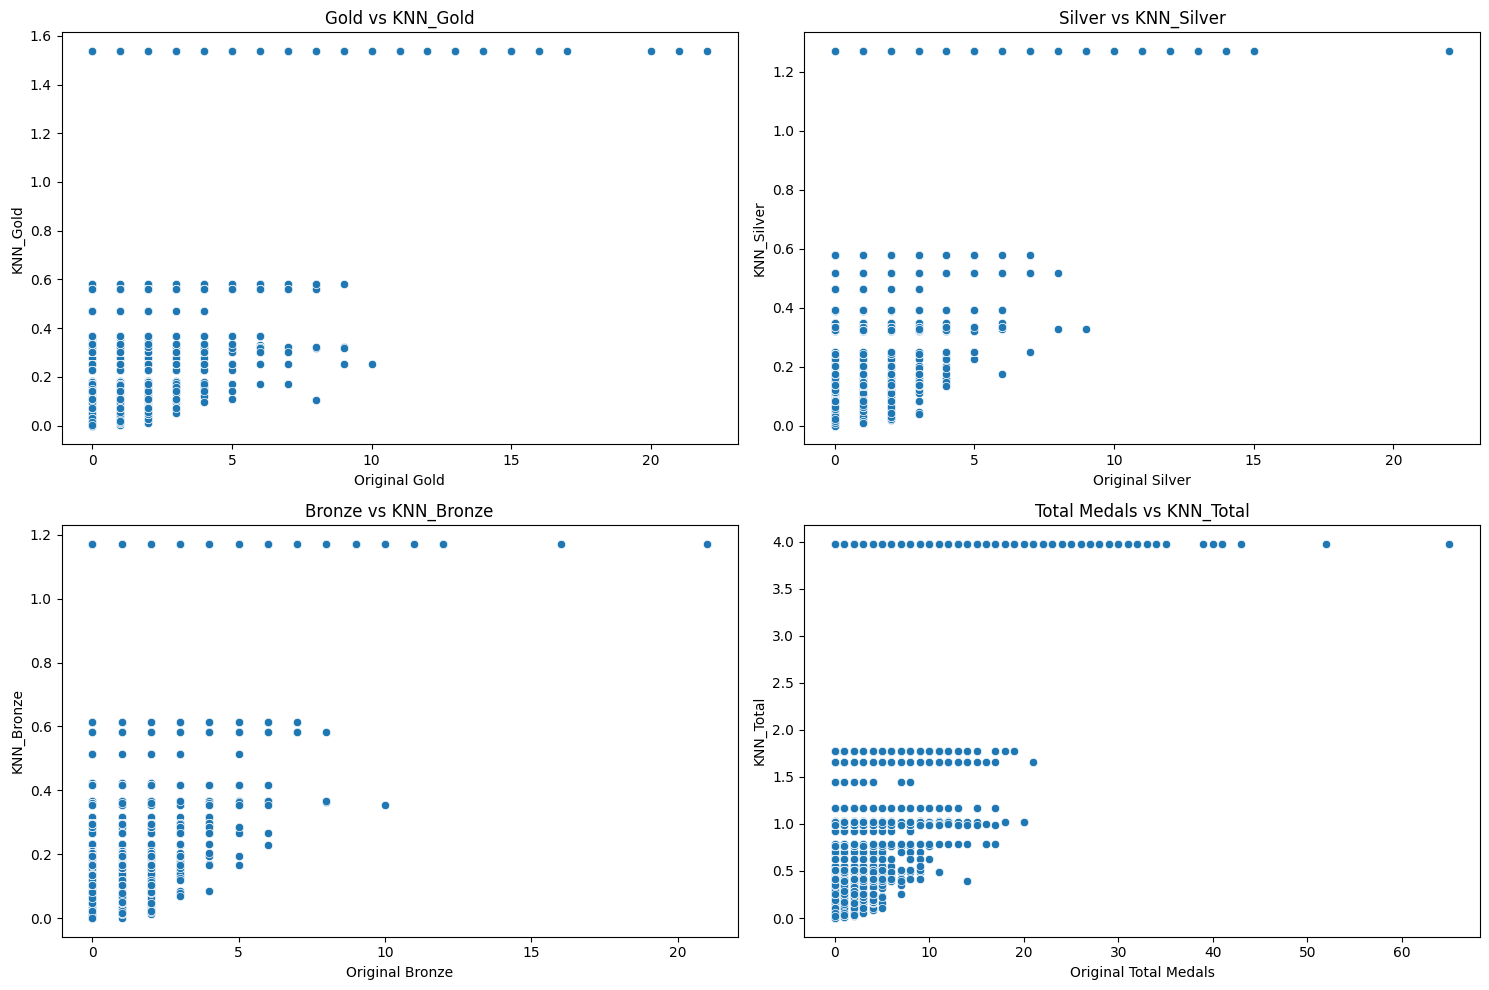

In [6]:
# Object Columns Encoding
train = replace_noc_with_knn(train, n_neighbors=5)
plot_knn_comparison(train)
train = encode_sport_code_by_events(train)

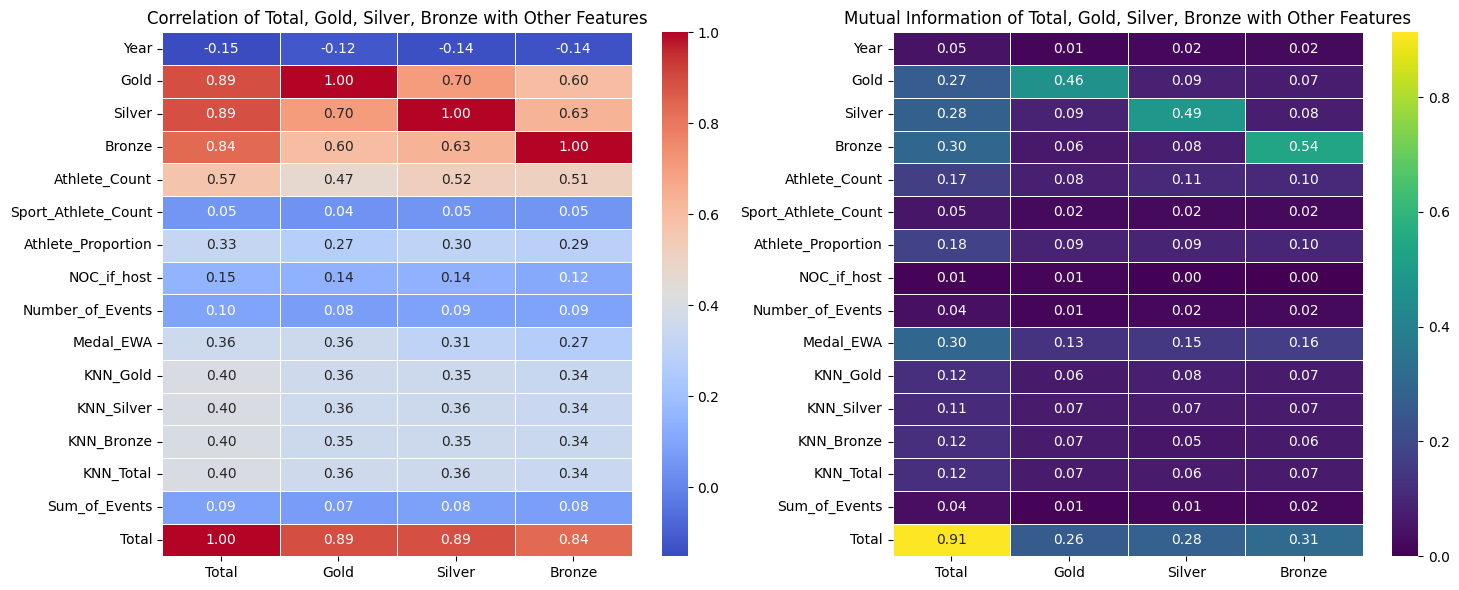

In [7]:
corr_matrix, mi_df = calculate_correlation_and_mi(train)
plot_correlation_and_mi(corr_matrix, mi_df)

**EDA**

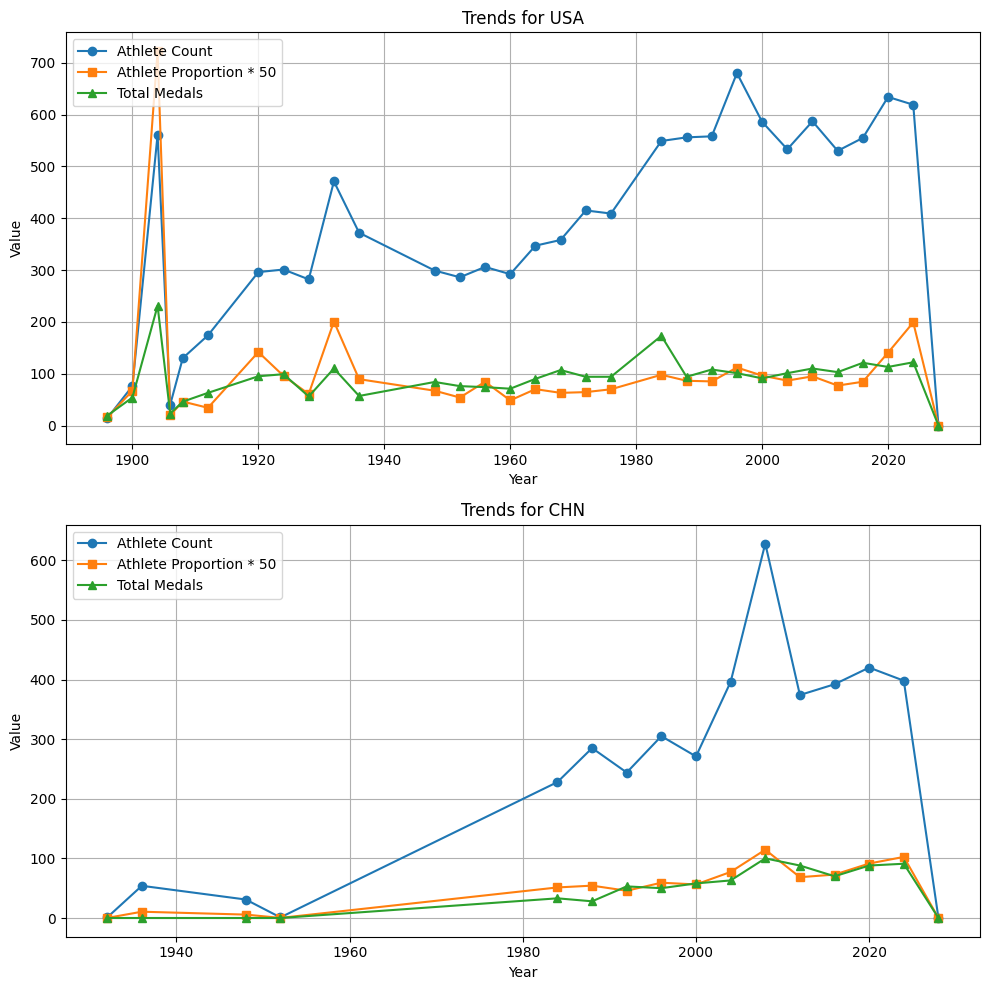

<Figure size 640x480 with 0 Axes>

In [8]:
athletes_effect = train.loc[:, ['Year', 'NOC', 'Gold', 'Silver','Bronze', 'Athlete_Count', 'Athlete_Proportion']].groupby(['Year', 'NOC']).sum().reset_index()
athletes_effect['Total_Medals'] = athletes_effect['Gold'] + athletes_effect['Silver'] + athletes_effect['Bronze']

selected_countries = ['USA', 'CHN']
filtered_data = athletes_effect[athletes_effect['NOC'].isin(selected_countries)]

fig, axes = plt.subplots(len(selected_countries), 1, figsize=(10, 5 * len(selected_countries)))

for i, country in enumerate(selected_countries):
    country_data = filtered_data[filtered_data['NOC'] == country]
    axes[i].plot(country_data['Year'], country_data['Athlete_Count'], label='Athlete Count', marker='o')
    axes[i].plot(country_data['Year'], country_data['Athlete_Proportion']*50, label='Athlete Proportion * 50', marker='s')
    axes[i].plot(country_data['Year'], country_data['Total_Medals'], label='Total Medals', marker='^')
    
    axes[i].set_title(f'Trends for {country}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Value')
    axes[i].legend(loc='upper left')
    axes[i].grid(True)

plt.tight_layout()

plt.show()
plt.savefig("Correlation of (Athlete_Count and Athlete_Proportion) and Total_Medals.png", dpi=300, bbox_inches='tight')


In [9]:
average_data = athletes_effect.groupby('Year').agg({
    'Athlete_Count': 'mean',
    'Athlete_Proportion': 'mean',
    'Total_Medals': 'mean'
}).reset_index()

correlation_matrix = average_data[['Athlete_Count', 'Athlete_Proportion', 'Total_Medals']].corr()
print("Correlation matrix for averaged data:")
print(correlation_matrix)

mi = mutual_info_regression(average_data[['Athlete_Count', 'Athlete_Proportion']], average_data['Total_Medals'], random_state=0)
mi_results = dict(zip(average_data[['Athlete_Count', 'Athlete_Proportion']].columns, mi))

print("\nMutual Information for averaged data:")
for feature, value in mi_results.items():
    print(f"  {feature} -> Total_Medals: {value:.4f}")

Correlation matrix for averaged data:
                    Athlete_Count  Athlete_Proportion  Total_Medals
Athlete_Count             1.00000            0.280760      0.404280
Athlete_Proportion        0.28076            1.000000      0.967284
Total_Medals              0.40428            0.967284      1.000000

Mutual Information for averaged data:
  Athlete_Count -> Total_Medals: 0.4791
  Athlete_Proportion -> Total_Medals: 1.3602


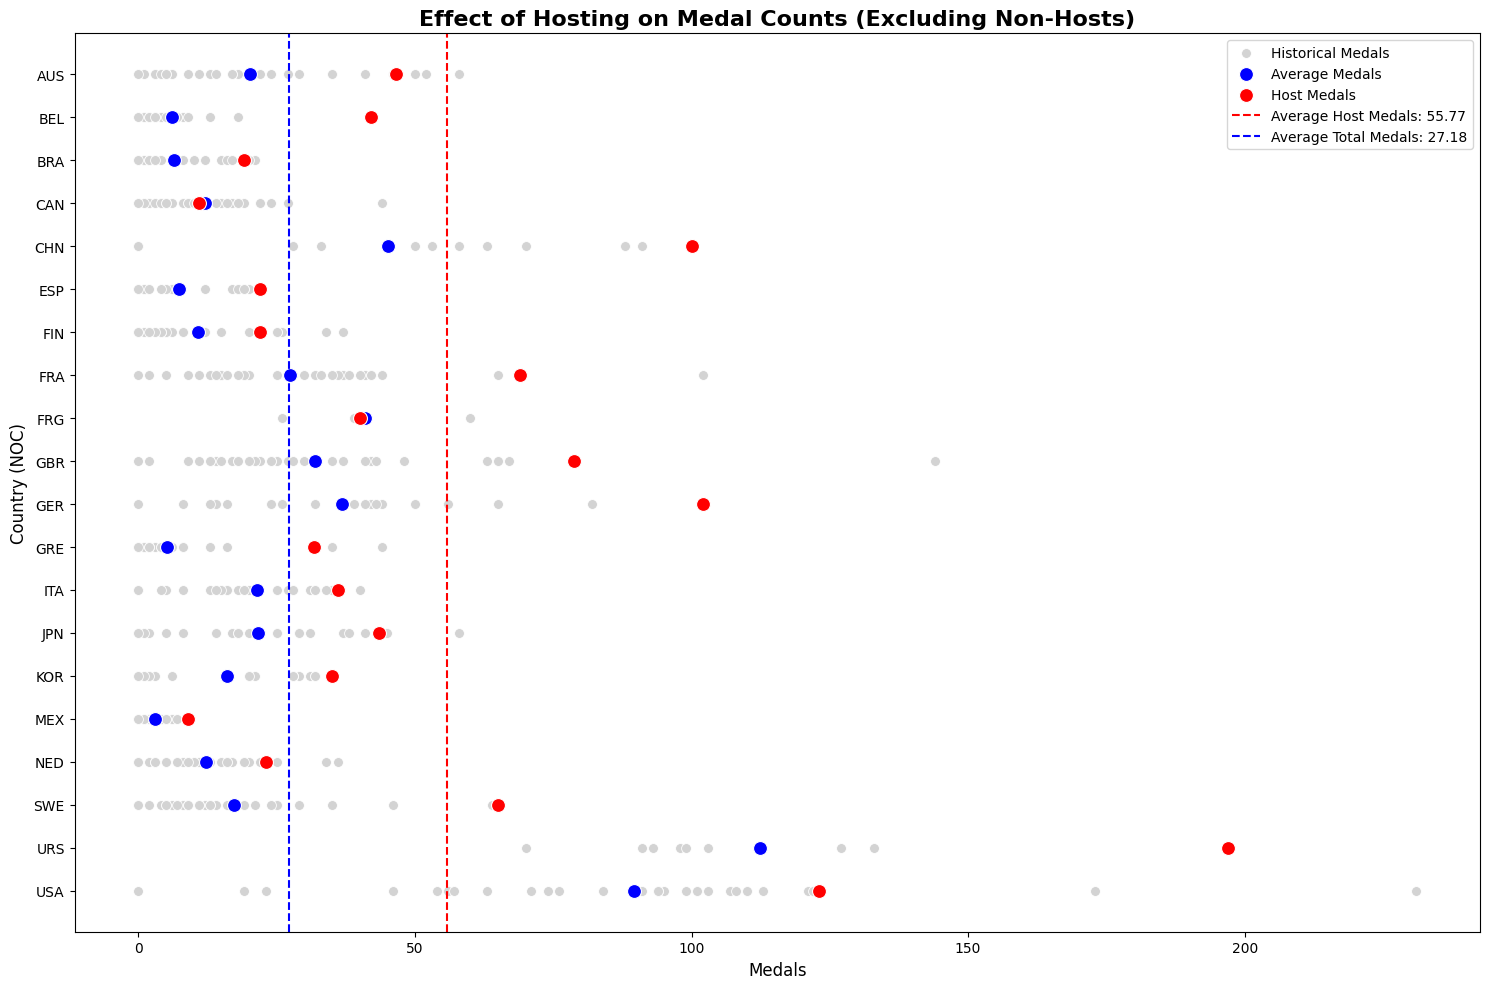

<Figure size 640x480 with 0 Axes>

In [10]:
# Prepare data for Host Effect EDA
train_eda = train.groupby(['Year', 'NOC'])[['Gold', 'Silver', 'Bronze']].sum().sort_values(by=['Year', 'Gold', 'Silver', 'Bronze'], ascending=[False, False, False, False]).reset_index()
train_eda = merge_hosts(train_eda, hosts)
train_eda

df_new = train_eda.copy()
df_new['Total_Medals'] = df_new[['Gold', 'Silver', 'Bronze']].sum(axis=1)

host_data = df_new[df_new['NOC_if_host'] == 1]
host_medals = host_data.groupby('NOC')['Total_Medals'].mean().reset_index()
host_medals.columns = ['NOC', 'Host_Medals']

country_avg_medals = df_new.groupby('NOC')[['Gold', 'Silver', 'Bronze']].mean().sum(axis=1).reset_index()
country_avg_medals.columns = ['NOC', 'Avg_Medals']

historical_medals = df_new.groupby(['NOC', 'Year'])['Total_Medals'].sum().reset_index()

final_data = country_avg_medals.merge(host_medals, on='NOC', how='left').fillna(0)
final_data = final_data.sort_values(by='Avg_Medals', ascending=False)
final_data = final_data[final_data['Host_Medals'] > 0]

# For each countries, Average Medal and Host Medal and all historical medals
plt.figure(figsize=(15, 10))
sns.scatterplot(
    data=historical_medals[historical_medals['NOC'].isin(final_data['NOC'])],
    x='Total_Medals',
    y='NOC',
    color='lightgray',
    s=50,
    label='Historical Medals',
)
sns.scatterplot(
    data=final_data,
    x='Avg_Medals',
    y='NOC',
    color='blue',
    s=100,
    label='Average Medals',
)
sns.scatterplot(
    data=final_data,
    x='Host_Medals',
    y='NOC',
    color='red',
    s=100,
    label='Host Medals',
)

avg_host_medals = final_data['Host_Medals'].mean()
avg_total_medals = final_data['Avg_Medals'].mean()

plt.axvline(avg_host_medals, color='red', linestyle='--', label=f'Average Host Medals: {avg_host_medals:.2f}')
plt.axvline(avg_total_medals, color='blue', linestyle='--', label=f'Average Total Medals: {avg_total_medals:.2f}')
plt.title('Effect of Hosting on Medal Counts (Excluding Non-Hosts)', fontsize=16, fontweight='bold')
plt.xlabel('Medals', fontsize=12)
plt.ylabel('Country (NOC)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("Effect of Hosting on Medal Counts (Excluding Non-Hosts).png", dpi=300, bbox_inches='tight')


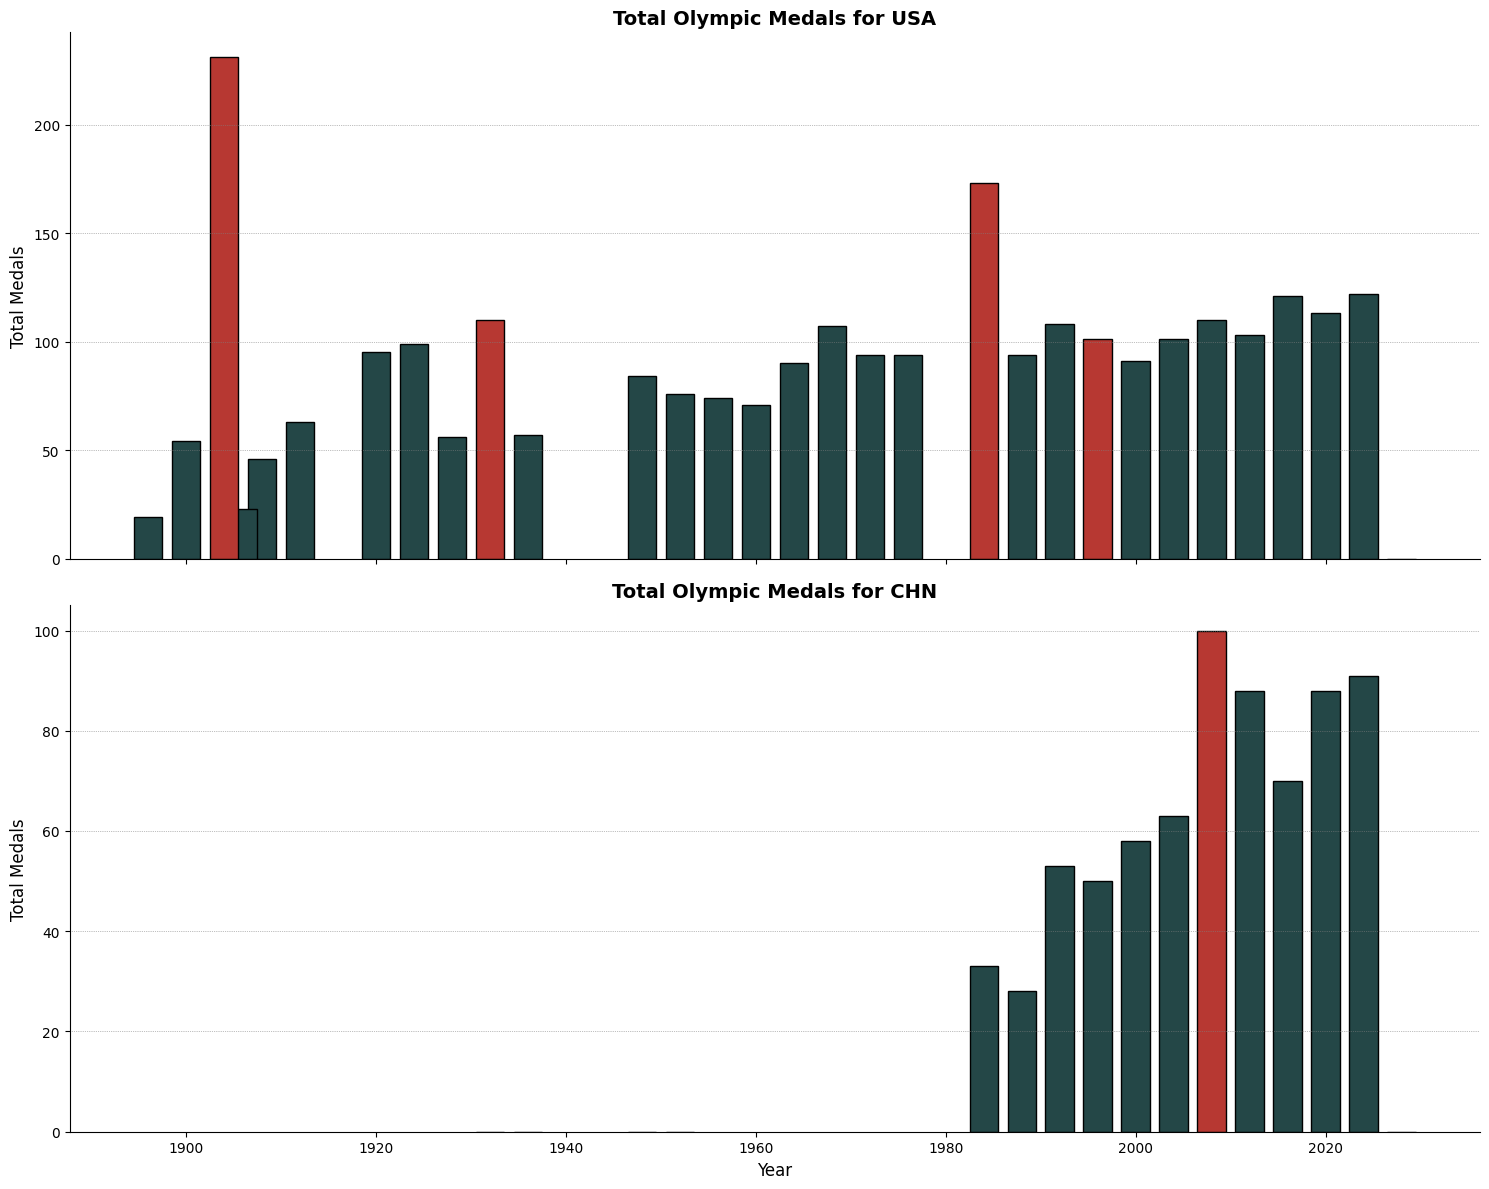

<Figure size 640x480 with 0 Axes>

In [11]:
# Total Medals for Countries Through Time
countries = ['USA', 'CHN']
filtered_data = df_new[df_new['NOC'].isin(countries)]

fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

for i, country in enumerate(countries):
    temp = filtered_data[filtered_data['NOC'] == country]
    color = ['#B73832' if is_host == 1 else '#244747' for is_host in temp['NOC_if_host']]

    axes[i].bar(temp['Year'], temp['Total_Medals'], width=3, color=color, edgecolor='black')
    axes[i].set_title(f'Total Olympic Medals for {country}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Total Medals', fontsize=12)
    axes[i].grid(axis='y', linestyle=':', linewidth=0.5, color='gray')

    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

axes[-1].set_xlabel('Year', fontsize=12)
plt.tight_layout()
plt.show()
plt.savefig("Total Medals for Host and Not Host Years.png", dpi=300, bbox_inches='tight')


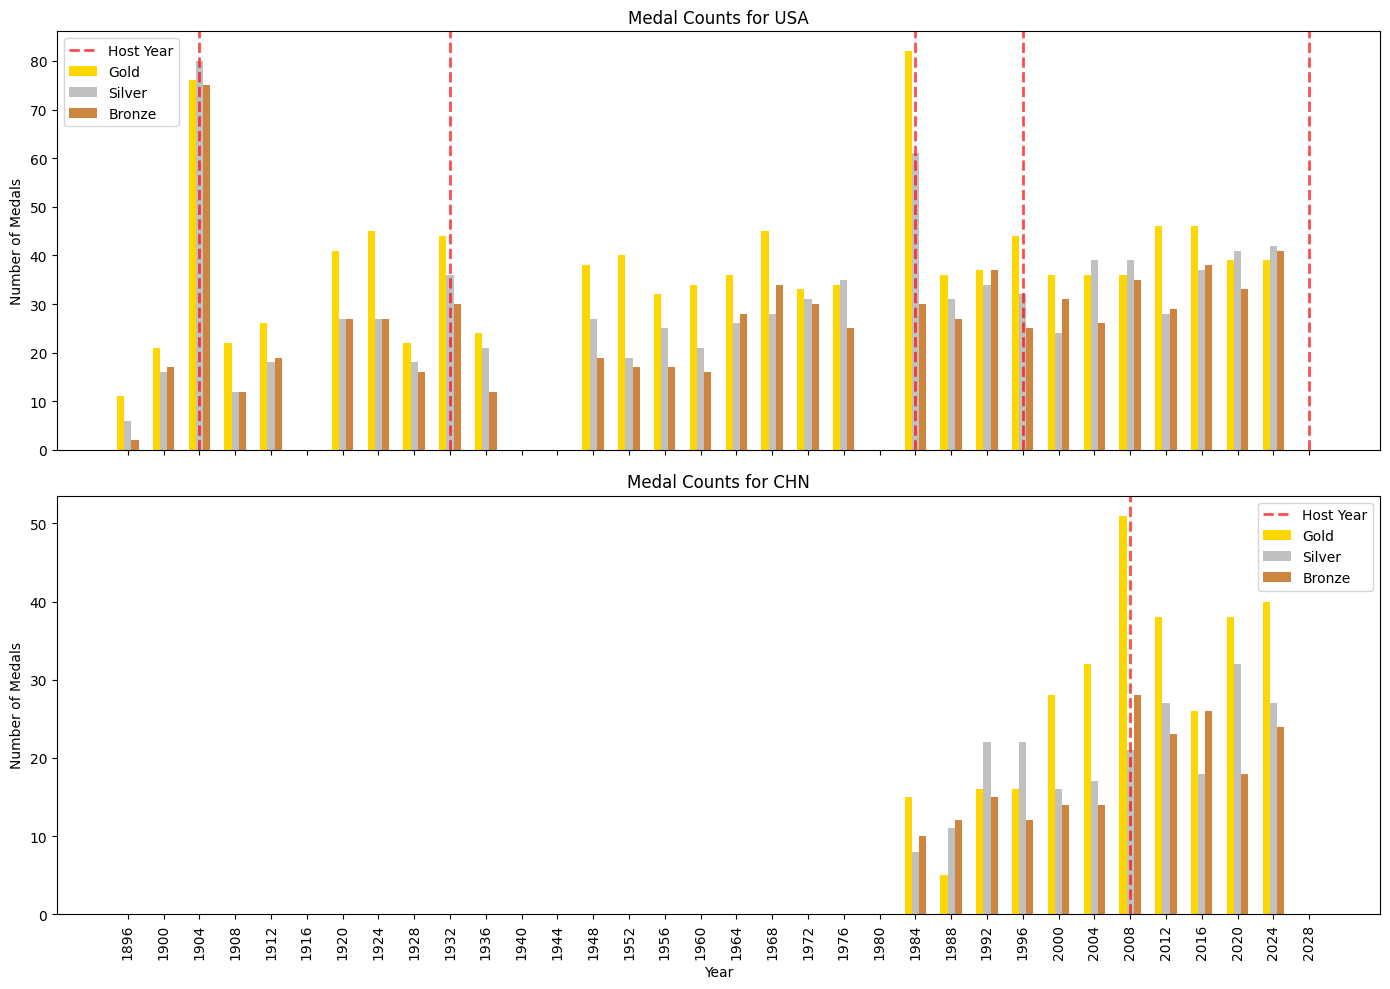

<Figure size 640x480 with 0 Axes>

In [12]:
# Gold, Silver, Bronze for countries in each year
medals_by_year = filtered_data.groupby(['Year', 'NOC'])[['Gold', 'Silver', 'Bronze']].sum().reset_index()

host_years = df_new[df_new['NOC_if_host'] == 1].groupby('NOC')['Year'].unique().reset_index()
host_years = {row['NOC']: row['Year'] for _, row in host_years.iterrows()}

all_years = np.arange(medals_by_year['Year'].min(), medals_by_year['Year'].max() + 1, 4)

fig, axes = plt.subplots(nrows=len(countries), ncols=1, figsize=(14, 10), sharex=True)
bar_width = 0.2

for i, country in enumerate(countries):
    country_data = medals_by_year[medals_by_year['NOC'] == country]
    country_data_full = pd.DataFrame({'Year': all_years})
    country_data_full = country_data_full.merge(country_data, on='Year', how='left').fillna(0)

    years = country_data_full['Year']
    gold = country_data_full['Gold']
    silver = country_data_full['Silver']
    bronze = country_data_full['Bronze']
    
    x = np.arange(len(years))
    
    axes[i].bar(x - bar_width, gold, width=bar_width, label='Gold', color='gold')
    axes[i].bar(x, silver, width=bar_width, label='Silver', color='silver')
    axes[i].bar(x + bar_width, bronze, width=bar_width, label='Bronze', color='peru')
    
    if country in host_years:
        for year in host_years[country]:
            if year in years.values:
                year_index = np.where(years == year)[0][0]
                axes[i].axvline(x=year_index, color='red', linestyle='--', linewidth=2, alpha=0.7, 
                                label='Host Year' if year == host_years[country][0] else "")
    
    axes[i].set_title(f'Medal Counts for {country}')
    axes[i].set_ylabel('Number of Medals')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(years, rotation=90)  # Rotate x-axis labels vertically
    axes[i].legend()

axes[-1].set_xlabel('Year')
plt.tight_layout()
plt.show()
plt.savefig("Medals for Host and Not Host Years.png", dpi=300, bbox_inches='tight')


Key Statistics
Mean Natural Log of Total Medals when Not Hosting: 2.368
Mean Natural Log of Total Medals when Hosting: 3.780
Standard Error of Natural Log of Total Medals when Not Hosting: 0.059
Standard Error of Natural Log of Total Medals when Hosting: 0.186
Standard Errors between means: 7.254

T-Test
Statistics = -6.032, p-value = 0.000
Different distributions (reject H0)


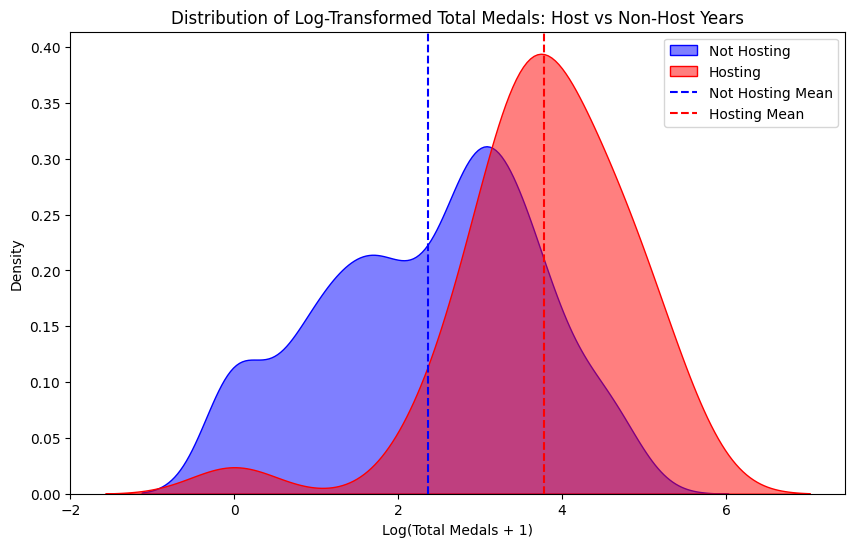

<Figure size 640x480 with 0 Axes>

In [13]:
# Statistic test
#To determine whether hosting the Olympics has a statistically significant effect on medal counts, we conducted a hypothesis test comparing the total medals won during host and non-host years. Since the total medals data is positively skewed, we applied a log transformation (using np.log1p) to make the distribution more normal, which is a key assumption for the t-test. We filtered the dataset to include only countries that have hosted the Olympics at least once, ensuring a fair comparison between host and non-host years for the same set of countries. The data was then split into two groups: host years (NOC_if_host == 1) and non-host years (NOC_if_host == 0). After applying the log transformation, we performed an independent two-sample t-test to compare the means of the log-transformed total medals between the two groups. The null hypothesis (H₀) was that the means are equal (no host effect), while the alternative hypothesis (H₁) was that the means are not equal (host effect exists). We calculated key statistics, including the means, standard errors, and the standardized difference between means. The t-test yielded a very small p-value (p < 0.05), leading us to reject the null hypothesis and conclude that there is a statistically significant difference in medal counts between host and non-host years. This suggests a host effect, where countries tend to win more medals when hosting the Olympics. The log transformation was crucial to ensure the validity of the t-test by addressing the skewness in the data.
df_new['Total_Medals'] = df_new[['Gold', 'Silver', 'Bronze']].sum(axis=1)

df_new['Total_Medals_NaturalLog'] = np.log1p(df_new['Total_Medals'])  # log(1 + x) to handle zeros

host_countries = df_new[df_new['NOC_if_host'] == 1]['NOC'].unique()
df_filtered = df_new[df_new['NOC'].isin(host_countries)]

host_data = df_filtered[df_filtered['NOC_if_host'] == 1]
non_host_data = df_filtered[df_filtered['NOC_if_host'] == 0]

not_hosting_mean = non_host_data['Total_Medals_NaturalLog'].mean()
hosting_mean = host_data['Total_Medals_NaturalLog'].mean()

not_hosting_std = non_host_data['Total_Medals_NaturalLog'].std()
hosting_std = host_data['Total_Medals_NaturalLog'].std()

not_hosting_samples = non_host_data['Total_Medals_NaturalLog'].count()
hosting_samples = host_data['Total_Medals_NaturalLog'].count()

not_hosting_std_error = not_hosting_std / np.sqrt(not_hosting_samples)
hosting_std_error = hosting_std / np.sqrt(hosting_samples)

difference = hosting_mean - not_hosting_mean
combined_std_error = np.sqrt((not_hosting_std**2 / not_hosting_samples) + (hosting_std**2 / hosting_samples))

stat, p = ttest_ind(non_host_data['Total_Medals_NaturalLog'], host_data['Total_Medals_NaturalLog'])

print("Key Statistics")
print(f"Mean Natural Log of Total Medals when Not Hosting: {not_hosting_mean:.3f}")
print(f"Mean Natural Log of Total Medals when Hosting: {hosting_mean:.3f}")
print(f"Standard Error of Natural Log of Total Medals when Not Hosting: {not_hosting_std_error:.3f}")
print(f"Standard Error of Natural Log of Total Medals when Hosting: {hosting_std_error:.3f}")
print(f"Standard Errors between means: {difference / combined_std_error:.3f}")

print("\nT-Test")
print(f"Statistics = {stat:.3f}, p-value = {p:.3f}")
if p < 0.05:
    print("Different distributions (reject H0)")
else:
    print("Same distributions (fail to reject H0)")

plt.figure(figsize=(10, 6))
sns.kdeplot(non_host_data['Total_Medals_NaturalLog'], label='Not Hosting', color='blue', shade=True, alpha=0.5)
sns.kdeplot(host_data['Total_Medals_NaturalLog'], label='Hosting', color='red', shade=True, alpha=0.5)
plt.axvline(not_hosting_mean, color='blue', linestyle='--', label='Not Hosting Mean')
plt.axvline(hosting_mean, color='red', linestyle='--', label='Hosting Mean')
plt.title('Distribution of Log-Transformed Total Medals: Host vs Non-Host Years')
plt.xlabel('Log(Total Medals + 1)')
plt.ylabel('Density')
plt.legend()
plt.show()
plt.savefig("Distribution of Total Medals When Hosting and Not Hosting.png", dpi=300, bbox_inches='tight')

**Time Series Features and Features Selection**

In [14]:
train

,Year,NOC,Gold,Silver,Bronze,Athlete_Count,Sport_Athlete_Count,Athlete_Proportion,NOC_host,NOC_if_host,Sport_Code,Number_of_Events,Medal_EWA,KNN_Gold,KNN_Silver,KNN_Bronze,KNN_Total,Sum_of_Events,Total
0,2028,AFG,0,0,0,0,0,0.000000,USA,0,ATH,0,0.000000,0.000000,0.000000,0.044287,0.044287,122959,0
1,2028,AFG,0,0,0,0,0,0.000000,USA,0,BOX,0,0.000000,0.000000,0.000000,0.044287,0.044287,16717,0
2,2028,AFG,0,0,0,0,0,0.000000,USA,0,CRD,0,0.000000,0.000000,0.000000,0.044287,0.044287,540,0
3,2028,AFG,0,0,0,0,0,0.000000,USA,0,JUD,0,0.000000,0.000000,0.000000,0.044287,0.044287,15909,0
4,2028,AFG,0,0,0,0,0,0.000000,USA,0,SHO,0,0.000000,0.000000,0.000000,0.044287,0.044287,19653,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29918,1896,ITA,0,0,0,1,38,0.026316,GRE,0,SHO,5,0.054049,0.336175,0.323878,0.361094,1.021147,19653,0
29919,1896,SUI,0,0,0,1,38,0.026316,GRE,0,SHO,5,0.118944,0.140843,0.173791,0.192975,0.507609,19653,0
29920,1896,SWE,0,0,0,1,63,0.015873,GRE,0,ATH,12,0.058845,0.302105,0.333537,0.353548,0.989190,122959,0
29921,1896,SWE,0,0,0,1,28,0.035714,GRE,0,GAR,8,0.078995,0.302105,0.333537,0.353548,0.989190,10371,0


Correlation matrix for shifted data:
                         Prev_Athlete_Count  Prev_Athlete_Proportion  \
Prev_Athlete_Count                 1.000000                 0.783845   
Prev_Athlete_Proportion            0.783845                 1.000000   
Total_Medals                       0.696175                 0.504940   

                         Total_Medals  
Prev_Athlete_Count           0.696175  
Prev_Athlete_Proportion      0.504940  
Total_Medals                 1.000000  

Mutual Information for shifted data:
  Prev_Athlete_Count -> Total_Medals: 0.4411
  Prev_Athlete_Proportion -> Total_Medals: 0.4579


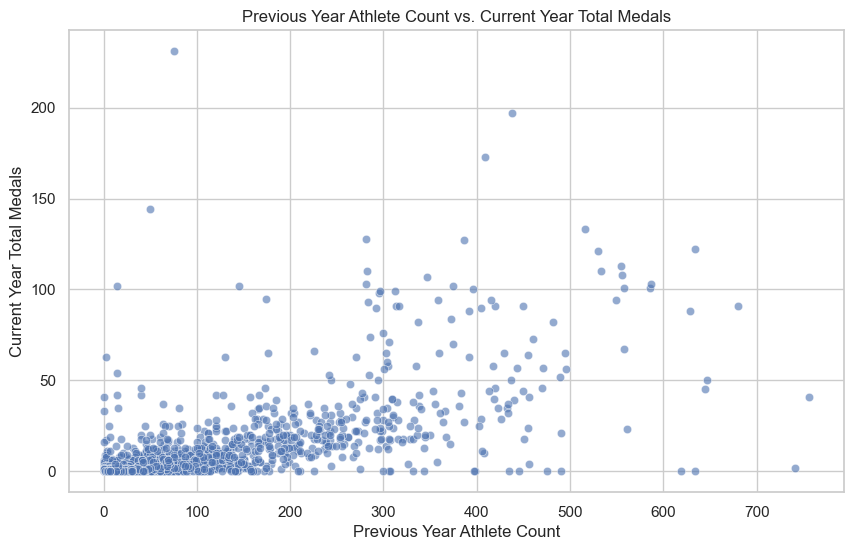

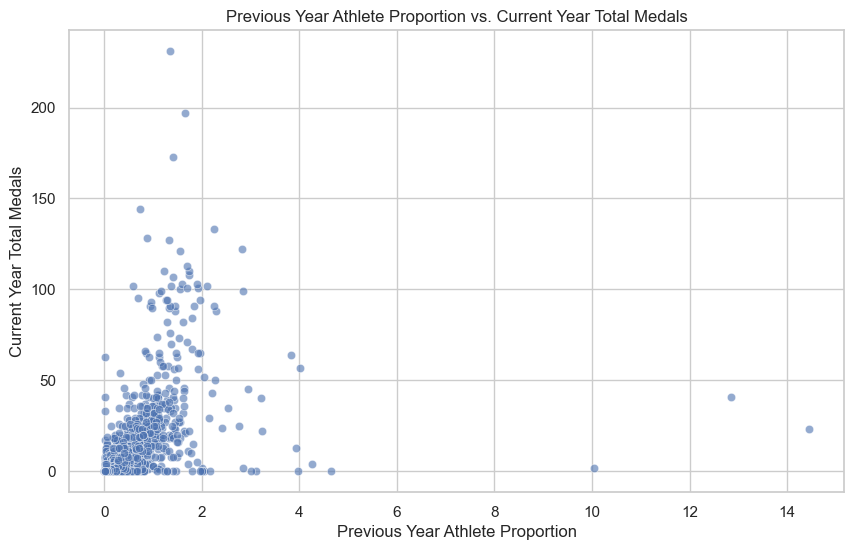

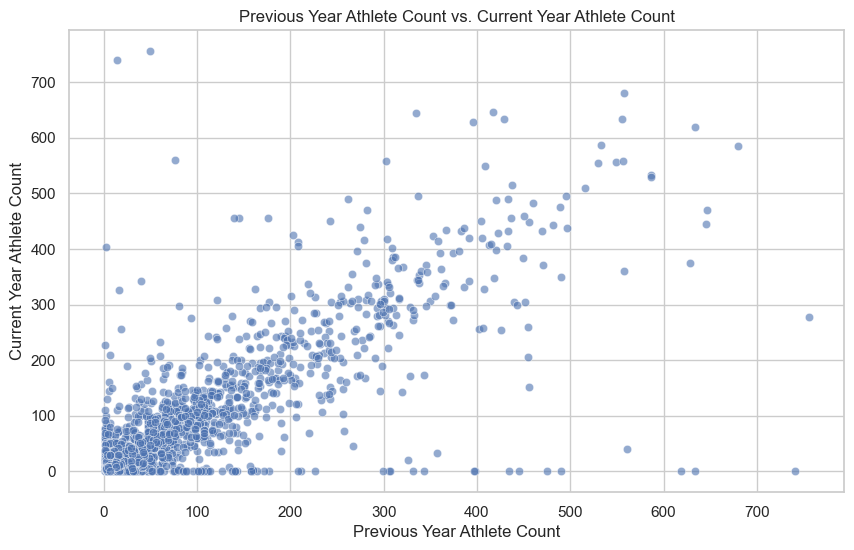

In [15]:
athletes_effect = train.loc[:, ['Year', 'NOC', 'Gold', 'Silver','Bronze', 'Athlete_Count', 'Athlete_Proportion']].groupby(['Year', 'NOC']).sum().reset_index()
athletes_effect['Total_Medals'] = athletes_effect['Gold'] + athletes_effect['Silver'] + athletes_effect['Bronze']

grouped_data = athletes_effect.groupby(['NOC']).apply(
    lambda x: x.sort_values('Year')
).reset_index(drop=True)

# Shift Athlete_Count and Athlete_Proportion to get previous year's values
grouped_data['Prev_Athlete_Count'] = grouped_data.groupby(['NOC'])['Athlete_Count'].shift(1)
grouped_data['Prev_Athlete_Proportion'] = grouped_data.groupby(['NOC'])['Athlete_Proportion'].shift(1)

# Drop rows with NaN values (due to shifting)
grouped_data = grouped_data.dropna()

# Calculate correlation matrix for shifted data
correlation_matrix = grouped_data[['Prev_Athlete_Count', 'Prev_Athlete_Proportion', 'Total_Medals']].corr()
print("Correlation matrix for shifted data:")
print(correlation_matrix)

mi = mutual_info_regression(grouped_data[['Prev_Athlete_Count', 'Prev_Athlete_Proportion']], grouped_data['Total_Medals'], random_state=0)
mi_results = dict(zip(grouped_data[['Prev_Athlete_Count', 'Prev_Athlete_Proportion']].columns, mi))

print("\nMutual Information for shifted data:")
for feature, value in mi_results.items():
    print(f"  {feature} -> Total_Medals: {value:.4f}")


sns.set_theme(style="whitegrid")

# Scatter plot: Prev_Athlete_Count vs. Total_Medals
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Prev_Athlete_Count', y='Total_Medals', data=grouped_data, alpha=0.6)
plt.title('Previous Year Athlete Count vs. Current Year Total Medals')
plt.xlabel('Previous Year Athlete Count')
plt.ylabel('Current Year Total Medals')
plt.show()

# Scatter plot: Prev_Athlete_Proportion vs. Total_Medals
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Prev_Athlete_Proportion', y='Total_Medals', data=grouped_data, alpha=0.6)
plt.title('Previous Year Athlete Proportion vs. Current Year Total Medals')
plt.xlabel('Previous Year Athlete Proportion')
plt.ylabel('Current Year Total Medals')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Prev_Athlete_Count', y='Athlete_Count', data=grouped_data, alpha=0.6)
plt.title('Previous Year Athlete Count vs. Current Year Athlete Count')
plt.xlabel('Previous Year Athlete Count')
plt.ylabel('Current Year Athlete Count')
plt.show()

In [16]:
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    """
    Plot multiple lag plots for a feature.
    """
    import math
    from pandas.plotting import lag_plot

    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


def create_lagged_features_safely(train, features_to_lag, max_lag=2):
    X = train.copy()

    X = X.sort_values(by=['NOC', 'Sport_Code', 'Year'])

    for feature in features_to_lag:
        for lag in range(1, max_lag + 1):
            lagged_series = X.groupby(['NOC', 'Sport_Code'])[feature].shift(lag)
            lagged_series = lagged_series.groupby([X['NOC'], X['Sport_Code']]).ffill().bfill().fillna(0)
            X[f'{feature}_lag{lag}'] = lagged_series

    return X

def plot_partial_autocorrelation(series, lags=10):
    """
    Plot the partial autocorrelation function (PACF) for a time series.
    """
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_pacf(series, lags=lags, ax=ax, method='ywm')
    plt.title(f'Partial Autocorrelation for {series.name}')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.show()




In [17]:
features_to_lag = ['Athlete_Count', 'Athlete_Proportion', 'Medal_EWA', 'Gold', 'Silver', 'Bronze']
X = create_lagged_features_safely(train, features_to_lag, max_lag=2)



In [19]:
# plot_lags(X['Gold'], lags=4, nrows=1)
# plt.show()

# plot_lags(X['Athlete_Proportion'], lags=4, nrows=1)
# plt.show()

# plot_lags(X['Medal_EWA'], lags=4, nrows=1)
# plt.show()

# plot_partial_autocorrelation(X['Gold'], lags=10)
# plot_partial_autocorrelation(X['Athlete_Proportion'], lags=10)
# plot_partial_autocorrelation(X['Medal_EWA'], lags=10)



In [20]:
X.columns

Index(['Year', 'NOC', 'Gold', 'Silver', 'Bronze', 'Athlete_Count',
       'Sport_Athlete_Count', 'Athlete_Proportion', 'NOC_host', 'NOC_if_host',
       'Sport_Code', 'Number_of_Events', 'Medal_EWA', 'KNN_Gold', 'KNN_Silver',
       'KNN_Bronze', 'KNN_Total', 'Sum_of_Events', 'Total',
       'Athlete_Count_lag1', 'Athlete_Count_lag2', 'Athlete_Proportion_lag1',
       'Athlete_Proportion_lag2', 'Medal_EWA_lag1', 'Medal_EWA_lag2',
       'Gold_lag1', 'Gold_lag2', 'Silver_lag1', 'Silver_lag2', 'Bronze_lag1',
       'Bronze_lag2'],
      dtype='object')

In [21]:
# # Print the dtypes of all columns in the DataFrame
# print("DataFrame dtypes:")
# print(X.dtypes)

# # Identify and print the columns that are not numeric or boolean
# invalid_columns = X.select_dtypes(exclude=["int", "float", "bool", "category"]).columns
# print("\nInvalid columns with problematic data types:")
# print(X[invalid_columns].dtypes)

# # Optionally, preview the data in the invalid columns
# print("\nSample data from invalid columns:")
# print(X[invalid_columns].head())


In [22]:
X = create_lagged_features_safely(train, features_to_lag, max_lag=2)

In [23]:
X = X[['Year','Gold', 'Silver', 'Bronze', 'NOC_if_host',
       'Number_of_Events', 'KNN_Gold', 'KNN_Silver',
       'KNN_Bronze', 'KNN_Total', 'Sum_of_Events',
       'Athlete_Count_lag1', 'Athlete_Count_lag2', 'Athlete_Proportion_lag1',
       'Athlete_Proportion_lag2', 'Medal_EWA_lag1',
       'Gold_lag1', 'Gold_lag2', 'Silver_lag1', 'Silver_lag2', 'Bronze_lag1',
       'Bronze_lag2']]

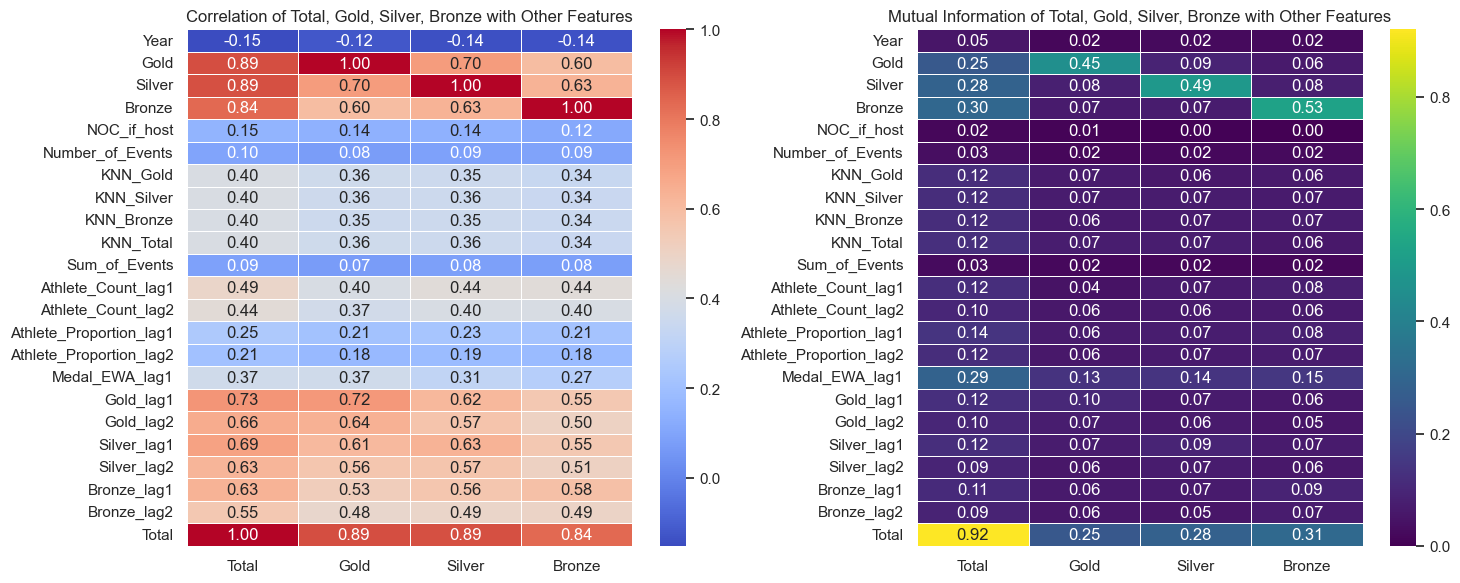

In [24]:
corr_matrix, mi_df = calculate_correlation_and_mi(X)
plot_correlation_and_mi(corr_matrix, mi_df)

In [25]:
'''# Country Participation
print(len(athletes['NOC'].unique()))
print(len(athletes[athletes['Year']>1999]['NOC'].unique()))
set(athletes['NOC'].unique()) - set(athletes[athletes['Year']>1999]['NOC'].unique())

all_years = medal['Year'].unique()
all_countries = medal['NOC'].unique()

full_grid = pd.MultiIndex.from_product([all_years, all_countries], names=['Year', 'NOC'])
full_df = pd.DataFrame(index=full_grid).reset_index()

participation = pd.merge(full_df, medal[['Year', 'NOC']], on=['Year', 'NOC'], how='left', indicator=True)

participation['Participated'] = (participation['_merge'] == 'both').astype(int)

pivot_table = participation.pivot(index='NOC', columns='Year', values='Participated').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap="coolwarm", cbar=True, linewidths=0.5, linecolor='gray')
plt.title("Participation of Countries by Year", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()'''

'# Country Participation\nprint(len(athletes[\'NOC\'].unique()))\nprint(len(athletes[athletes[\'Year\']>1999][\'NOC\'].unique()))\nset(athletes[\'NOC\'].unique()) - set(athletes[athletes[\'Year\']>1999][\'NOC\'].unique())\n\nall_years = medal[\'Year\'].unique()\nall_countries = medal[\'NOC\'].unique()\n\nfull_grid = pd.MultiIndex.from_product([all_years, all_countries], names=[\'Year\', \'NOC\'])\nfull_df = pd.DataFrame(index=full_grid).reset_index()\n\nparticipation = pd.merge(full_df, medal[[\'Year\', \'NOC\']], on=[\'Year\', \'NOC\'], how=\'left\', indicator=True)\n\nparticipation[\'Participated\'] = (participation[\'_merge\'] == \'both\').astype(int)\n\npivot_table = participation.pivot(index=\'NOC\', columns=\'Year\', values=\'Participated\').fillna(0)\n\nplt.figure(figsize=(12, 8))\nsns.heatmap(pivot_table, cmap="coolwarm", cbar=True, linewidths=0.5, linecolor=\'gray\')\nplt.title("Participation of Countries by Year", fontsize=16)\nplt.xlabel("Year", fontsize=12)\nplt.ylabel("Cou

In [26]:

X_train = X[X["Year"]!=2028]
y_G = X_train[["Gold"]]
y_S = X_train[["Silver"]]
y_B = X_train[["Bronze"]]

X_train = X_train.drop(['Gold','Silver','Bronze'],axis=1)

In [33]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

def KFold_training(X, y, model_class, model_params):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    models = []
    mapes = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        # y_train, y_val = y[train_idx], y[val_idx]
        # X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = model_class(**model_params)
        # Handle verbosity dynamically based on the model type
        if model_class.__name__ == "XGBRegressor":
            model = model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
        elif model_class.__name__ == "LGBMRegressor":
            model = model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='mape'
            )
        elif model_class.__name__ == "CatBoostRegressor":
            model = model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False,
                early_stopping_rounds=10
            )
        models.append(model)
        y_pred = model.predict(X_val)
        y_train_pred = model.predict(X_train)
        mape_train = mean_absolute_percentage_error(y_train_pred, y_train)
        mape = mean_absolute_percentage_error(y_pred, y_val)
        mapes.append(mape)
        print(f'Fold {fold+1} mean absolute percentage error for train is {mape_train}, for val is {mape}')
    return models, mapes

def ensemble_prediction(models, X):
    prediction = np.zeros(X.shape[0])
    for model in models:
        prediction = prediction + model.predict(X)
    return prediction/len(models)

In [35]:
xgb_params = {'n_estimators': 154, 'learning_rate': 0.041259284876469744, 'max_depth': 11, 'reg_alpha': 0.3824592797131241, 'reg_lambda': 0.8898611011911761, 'min_child_weight': 3.136009988767917, 'subsample': 0.7084239409438348, 'colsample_bytree': 0.92333323939882,
              'eval_metric': 'mape',
              'random_state': 42, 
              'enable_categorical':True
              #'verbose': 1
             } # mape 0.07738683573065815

split_index = int(0.8 * len(X_train))
# Dynamically split the data into training and validation sets
X_train_subset, X_val = X_train[:split_index], X_train[split_index:]
y_train_subset, y_val = y_G[:split_index], y_G[split_index:]

xgb_models, xgb_mapes = KFold_training(X_train, y_G, XGBRegressor, xgb_params)


y_pred = ensemble_prediction(xgb_models, X_val)
mape = mean_absolute_percentage_error(y_pred, y_val)
print(f'mape for ensemble is {mape}')


Fold 1 mean absolute percentage error for train is 0.9292043447494507, for val is 1.1002142429351807
Fold 2 mean absolute percentage error for train is 0.930289626121521, for val is 1.0330734252929688
Fold 3 mean absolute percentage error for train is 0.9269844889640808, for val is 1.0908995866775513
Fold 4 mean absolute percentage error for train is 0.930351972579956, for val is 1.3024272918701172
Fold 5 mean absolute percentage error for train is 0.9275933504104614, for val is 1.0936768054962158
mape for ensemble is 0.9168858408287613


In [32]:
import optuna
def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),  # L2 regularization
        'min_child_weight': trial.suggest_float('min_child_weight', 0.5, 4),
        'subsample': trial.suggest_float('subsample', 0.2, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1),
        'random_state': 42,
        'eval_metric': 'mape'
    }
    xgb_models, mapes = KFold_training(X_train, y_G, XGBRegressor, params)
        
    return np.mean(mapes)
    
study = optuna.create_study(direction='minimize')
study.optimize(xgb_objective, n_trials=50, timeout=1000)

print("Best MAPE:", study.best_value)
print("Best Parameters:", study.best_params)


[I 2025-01-26 19:30:22,049] A new study created in memory with name: no-name-341dbec8-569e-4b81-9845-cde7d395b301
[W 2025-01-26 19:30:22,066] Trial 0 failed with parameters: {'n_estimators': 428, 'learning_rate': 0.0748807085964919, 'max_depth': 8, 'reg_alpha': 0.13550585653506897, 'reg_lambda': 0.23009025031187047, 'min_child_weight': 1.1053102428771266, 'subsample': 0.6511336266974048, 'colsample_bytree': 0.4922196435339961} because of the following error: KeyError("None of [Index([    0,     1,     2,     3,     4,     5,     7,     8,     9,    10,\n       ...\n       26459, 26460, 26461, 26462, 26463, 26464, 26465, 26466, 26467, 26468],\n      dtype='int32', length=21175)] are in the [columns]").
Traceback (most recent call last):
  File "d:\Python\python3127\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Windows\Temp\ipykernel_18396\2074435381.py", line 15, in xgb_objective
    x

KeyError: "None of [Index([    0,     1,     2,     3,     4,     5,     7,     8,     9,    10,\n       ...\n       26459, 26460, 26461, 26462, 26463, 26464, 26465, 26466, 26467, 26468],\n      dtype='int32', length=21175)] are in the [columns]"